In [70]:
X_DIM = 256
Y_DIM = 256
UNPROCESSED_DIRECTORY = "CNN_synth_testset"
PROCESSED_DIRECTORY = "processed_images"
CROP = False
import os
import numpy as np
from PIL import Image as im_lib
from PIL import ImageFilter
from keras.layers import Layer
from keras import models
from keras import layers
from keras.utils import Sequence
from keras.metrics import Metric
import keras.backend as backend
import tensorflow as tf
from math import ceil
from sklearn.model_selection import train_test_split
import time

In [2]:
def obtain_image_paths(unprocessed_directory = UNPROCESSED_DIRECTORY):
    data_directory = os.listdir("./"+unprocessed_directory)
    list_of_image_paths = []
    for dirpath, dirname, filename in os.walk("./"+unprocessed_directory):
        if not dirname:
            for dirpath2, dirname2, filename2 in os.walk(dirpath):
                for filedir in filename2:
                    list_of_image_paths.append(dirpath+"/"+filedir)
    return list_of_image_paths

In [3]:
#Create constants and import libraries
def categorical_output(image_path):
    keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan","stylegan2", "stylegan",
           "whichfaceisreal"]
    category = [0] * (len(keywords) + 1)
    for kwd_index in range(len(keywords)):
        kwd = keywords[kwd_index]
        if kwd in image_path:
            category[kwd_index] = 1
            return category
    category[-1] = 1
    return category
class ImageBatchSequence(Sequence):
    def __init__(self, x_set, batch_size, x_dim = X_DIM, y_dim = Y_DIM, filter_function = None, 
                 output_function = None, normalizing_factor = 255):
        self.x = x_set
        if output_function is None:
            y_set = [(1 if "fake" in image_path else 0) for image_path in x_set] #This makes the output to be 1 (AI-generated) if FAKE is in pathname.
            #                                                  # Otherwise, it makes the output 0 (not AI-generated)
        else:
            y_set = [output_function(image_path) for image_path in x_set]
        self.y = y_set
        self.batch_size = batch_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.filter_function = filter_function
        self.normalizing_factor = normalizing_factor
    def __len__(self):
        return ceil(len(self.x)/self.batch_size)
    def __getitem__(self, index):
        low = index * self.batch_size
        high = min(low+self.batch_size, len(self.x))
        batch_x = self.x[low : high]
        batch_y = self.y[low : high]
        image_x_batch = []
        for image_path in batch_x:
            image = im_lib.open(image_path)
            if self.filter_function is not None:
                image = self.filter_function(image)
            image_array = np.asarray(image).reshape(self.x_dim,self.y_dim,3)/self.normalizing_factor
            image_x_batch.append(image_array)
        return np.array(image_x_batch), np.array(batch_y)

In [4]:
X = obtain_image_paths(PROCESSED_DIRECTORY)
y = [categorical_output(x) for x in X]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle = True,
                                                       random_state = 440,
                                                       test_size = .2, stratify = y)

In [6]:
keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan", "stylegan",
           "stylegan2","whichfaceisreal"]
for kwd in keywords:
    print(kwd+":"+str(y_train.count(categorical_output(kwd))))
print("real : "+str(y_train.count(categorical_output("fuck"))))
print(";;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;")
for kwd in keywords:
    print(kwd+":"+str(y_test.count(categorical_output(kwd))))
print("real : "+str(y_test.count(categorical_output("fuck"))))

biggan:1600
crn:5106
cyclegan:1057
deepfake:4324
gaugan:4000
imle:5105
progan:3200
san:174
seeingdark:144
stargan:1599
stylegan:4793
stylegan2:6390
whichfaceisreal:800
real : 33960
;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;
biggan:400
crn:1276
cyclegan:264
deepfake:1081
gaugan:1000
imle:1277
progan:800
san:43
seeingdark:36
stargan:400
stylegan:1198
stylegan2:1598
whichfaceisreal:200
real : 8490


In [7]:
X_train_train,X_val,y_train_train,y_val = train_test_split(X_train, y_train,
                                                          test_size=.2,
                                                          shuffle=True,
                                                          stratify=y_train,
                                                          random_state=440)

In [8]:
model = models.Sequential()
model.add(layers.Conv2D( 32, (3,3), activation='relu', input_shape=(256,256,3,)))
model.add( layers.MaxPooling2D( (2,2), strides = 2 ) )
model.add( layers.Conv2D(64, (3,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )
model.add( layers.Flatten() )
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [66]:
class MulticlassPrecisionMetric(Metric):
    def __init__(self, name = "mp", category_tested = 0):
        super(MulticlassPrecisionMetric,self).__init__(name = name)
        self.category_tested = category_tested
        self.multi_true_positives = self.add_weight(name = 'tp' + str(self.category_tested), initializer = 'zeros')
        self.multi_tf_positives = self.add_weight(name = 'tfp' + str(self.category_tested), initializer = 'zeros')
        self.mp = self.add_weight(name = 'mp' + str(self.category_tested), initializer = 'zeros')
    def update_state(self, y_true, y_pred, sample_weight = None):
        y_true = tf.argmax(y_true, axis = -1)
        y_pred = tf.argmax(y_pred, axis = -1)
        tp = tf.reduce_sum(\
                         tf.cast(tf.equal(y_true,self.category_tested),tf.float32)\
                         *tf.cast(tf.equal(y_pred,self.category_tested),tf.float32))
        self.multi_true_positives.assign_add(tp)
        self.multi_tf_positives.assign_add(\
                                           tf.reduce_sum(\
                                                       tf.cast(tf.equal(y_pred,self.category_tested),tf.float32)))
        self.mp.assign(self.multi_true_positives/(self.multi_tf_positives+backend.epsilon()))
    def result(self):
        return self.mp
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [52]:
class MulticlassRecallMetric(Metric):
    def __init__(self, name = "mp", category_tested = 0):
        super(MulticlassRecallMetric,self).__init__(name = name)
        self.category_tested = category_tested
        self.multi_true_positives = self.add_weight(name = 'tp' + str(self.category_tested), initializer = 'zeros')
        self.multi_predic = self.add_weight(name = 'tpr' + str(self.category_tested), initializer = 'zeros')
        self.mr = self.add_weight(name = 'mr' + str(self.category_tested), initializer = 'zeros')
    def update_state(self, y_true, y_pred,sample_weight = None):
        y_true = tf.argmax(y_true, axis = -1)
        y_pred = tf.argmax(y_pred, axis = -1)
        tp = tf.reduce_sum(\
                         tf.cast(tf.equal(y_true,self.category_tested),tf.float32)\
                         *tf.cast(tf.equal(y_pred,self.category_tested),tf.float32))
        self.multi_true_positives.assign_add(tp)
        self.multi_predic.assign_add(\
                                           tf.reduce_sum(\
                                                       tf.cast(tf.equal(y_true,self.category_tested),tf.float32)))
        self.mr.assign(self.multi_true_positives/(self.multi_predic+backend.epsilon()))
    def result(self):
        return self.mr
    def get_config(self):
        base_config = super().get_config()
        return {**base_config}

In [11]:
keywords = ["biggan", "crn", "cyclegan","deepfake","gaugan","imle","progan","san","seeingdark","stargan","stylegan2",
            "stylegan", "whichfaceisreal"]
METRICS = []
for kwd_index in range(len(keywords)):
    precision_metric = MulticlassPrecisionMetric(name = "precision_"+keywords[kwd_index], 
                                                 category_tested = kwd_index)
    recall_metric = MulticlassRecallMetric(name = "recall_"+keywords[kwd_index], 
                                                 category_tested = kwd_index)
    METRICS.append(precision_metric)
    METRICS.append(recall_metric)
precision_metric = MulticlassPrecisionMetric(name = "precision_real", category_tested = len(keywords))
recall_metric = MulticlassRecallMetric(name = "recall_real", category_tested = len(keywords))
METRICS.append(precision_metric)
METRICS.append(recall_metric)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = [METRICS])

In [12]:
def HPF_filter(image):
    return im_lib.fromarray(np.asarray(image)-np.asarray(image.filter(ImageFilter.GaussianBlur)))

In [13]:
train_sequence = ImageBatchSequence(X_train_train, batch_size = 16, filter_function = HPF_filter, 
                                    output_function = categorical_output)
validation_sequence = ImageBatchSequence(X_val, batch_size = 16, filter_function = HPF_filter, 
                                    output_function = categorical_output)

In [14]:
history = model.fit(train_sequence, epochs = 20, validation_data = validation_sequence)

Epoch 1/20
3613/3613 [==============================] - 596s 164ms/step - loss: 0.6511 - precision_biggan: 0.5019 - recall_biggan: 0.1008 - precision_crn: 0.9744 - recall_crn: 0.9589 - precision_cyclegan: 0.3927 - recall_cyclegan: 0.1277 - precision_deepfake: 0.9475 - recall_deepfake: 0.9390 - precision_gaugan: 0.6165 - recall_gaugan: 0.5009 - precision_imle: 0.9601 - recall_imle: 0.9373 - precision_progan: 0.7047 - recall_progan: 0.3953 - precision_san: 0.2381 - recall_san: 0.0360 - precision_seeingdark: 0.7317 - recall_seeingdark: 0.5217 - precision_stargan: 0.9479 - recall_stargan: 0.8530 - precision_stylegan2: 0.6708 - recall_stylegan2: 0.6645 - precision_stylegan: 0.7724 - recall_stylegan: 0.5657 - precision_whichfaceisreal: 0.5375 - recall_whichfaceisreal: 0.2688 - precision_real: 0.7832 - recall_real: 0.9326 - val_loss: 0.3390 - val_precision_biggan: 0.6931 - val_recall_biggan: 0.4094 - val_precision_crn: 0.9752 - val_recall_crn: 1.0000 - val_precision_cyclegan: 0.6711 - val_rec

Epoch 6/20
3613/3613 [==============================] - 425s 118ms/step - loss: 0.0250 - precision_biggan: 0.9835 - recall_biggan: 0.9781 - precision_crn: 0.9988 - recall_crn: 0.9988 - precision_cyclegan: 0.9763 - recall_cyclegan: 0.9752 - precision_deepfake: 0.9945 - recall_deepfake: 0.9948 - precision_gaugan: 0.9925 - recall_gaugan: 0.9931 - precision_imle: 0.9971 - recall_imle: 0.9980 - precision_progan: 0.9875 - recall_progan: 0.9863 - precision_san: 0.9710 - recall_san: 0.9640 - precision_seeingdark: 0.9913 - recall_seeingdark: 0.9913 - precision_stargan: 0.9961 - recall_stargan: 0.9969 - precision_stylegan2: 0.9894 - recall_stylegan2: 0.9898 - precision_stylegan: 0.9919 - recall_stylegan: 0.9901 - precision_whichfaceisreal: 0.9842 - recall_whichfaceisreal: 0.9719 - precision_real: 0.9942 - recall_real: 0.9948 - val_loss: 0.7136 - val_precision_biggan: 0.7552 - val_recall_biggan: 0.3375 - val_precision_crn: 0.9951 - val_recall_crn: 0.9990 - val_precision_cyclegan: 0.8365 - val_rec

Epoch 11/20
3613/3613 [==============================] - 407s 113ms/step - loss: 0.0145 - precision_biggan: 0.9882 - recall_biggan: 0.9836 - precision_crn: 0.9995 - recall_crn: 0.9993 - precision_cyclegan: 0.9906 - recall_cyclegan: 0.9929 - precision_deepfake: 0.9977 - recall_deepfake: 0.9983 - precision_gaugan: 0.9959 - recall_gaugan: 0.9953 - precision_imle: 0.9985 - recall_imle: 0.9990 - precision_progan: 0.9887 - recall_progan: 0.9910 - precision_san: 0.9857 - recall_san: 0.9928 - precision_seeingdark: 0.9914 - recall_seeingdark: 1.0000 - precision_stargan: 0.9984 - recall_stargan: 0.9984 - precision_stylegan2: 0.9930 - recall_stylegan2: 0.9933 - precision_stylegan: 0.9953 - recall_stylegan: 0.9961 - precision_whichfaceisreal: 0.9922 - recall_whichfaceisreal: 0.9891 - precision_real: 0.9975 - recall_real: 0.9972 - val_loss: 1.6355 - val_precision_biggan: 0.3647 - val_recall_biggan: 0.6062 - val_precision_crn: 1.0000 - val_recall_crn: 0.9951 - val_precision_cyclegan: 0.7216 - val_re

Epoch 16/20
3613/3613 [==============================] - 413s 114ms/step - loss: 0.0140 - precision_biggan: 0.9953 - recall_biggan: 0.9898 - precision_crn: 1.0000 - recall_crn: 1.0000 - precision_cyclegan: 0.9953 - recall_cyclegan: 0.9917 - precision_deepfake: 0.9986 - recall_deepfake: 0.9983 - precision_gaugan: 0.9950 - recall_gaugan: 0.9962 - precision_imle: 0.9990 - recall_imle: 0.9990 - precision_progan: 0.9914 - recall_progan: 0.9930 - precision_san: 0.9714 - recall_san: 0.9784 - precision_seeingdark: 0.9828 - recall_seeingdark: 0.9913 - precision_stargan: 0.9984 - recall_stargan: 0.9992 - precision_stylegan2: 0.9949 - recall_stylegan2: 0.9953 - precision_stylegan: 0.9953 - recall_stylegan: 0.9948 - precision_whichfaceisreal: 0.9953 - recall_whichfaceisreal: 0.9891 - precision_real: 0.9978 - recall_real: 0.9979 - val_loss: 1.4673 - val_precision_biggan: 0.6745 - val_recall_biggan: 0.4469 - val_precision_crn: 1.0000 - val_recall_crn: 0.9951 - val_precision_cyclegan: 0.7823 - val_re

In [15]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'precision_biggan', 'recall_biggan', 'precision_crn', 'recall_crn', 'precision_cyclegan', 'recall_cyclegan', 'precision_deepfake', 'recall_deepfake', 'precision_gaugan', 'recall_gaugan', 'precision_imle', 'recall_imle', 'precision_progan', 'recall_progan', 'precision_san', 'recall_san', 'precision_seeingdark', 'recall_seeingdark', 'precision_stargan', 'recall_stargan', 'precision_stylegan2', 'recall_stylegan2', 'precision_stylegan', 'recall_stylegan', 'precision_whichfaceisreal', 'recall_whichfaceisreal', 'precision_real', 'recall_real', 'val_loss', 'val_precision_biggan', 'val_recall_biggan', 'val_precision_crn', 'val_recall_crn', 'val_precision_cyclegan', 'val_recall_cyclegan', 'val_precision_deepfake', 'val_recall_deepfake', 'val_precision_gaugan', 'val_recall_gaugan', 'val_precision_imle', 'val_recall_imle', 'val_precision_progan', 'val_recall_progan', 'val_precision_san', 'val_recall_san', 'val_precision_seeingdark', 'val_recall_seeingdark', 'val_precision_starg

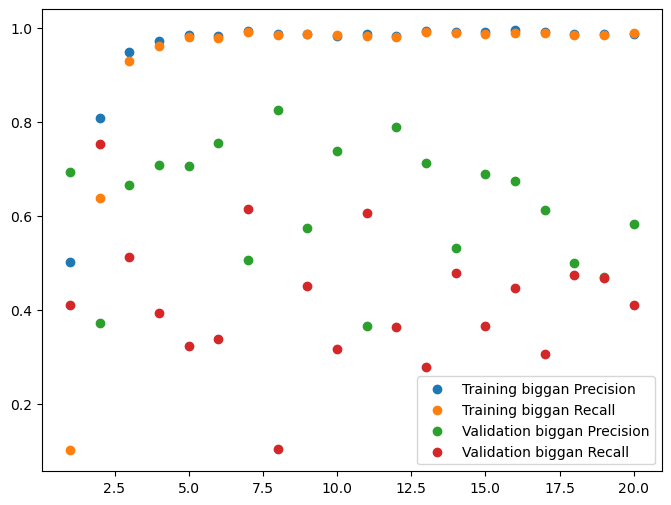

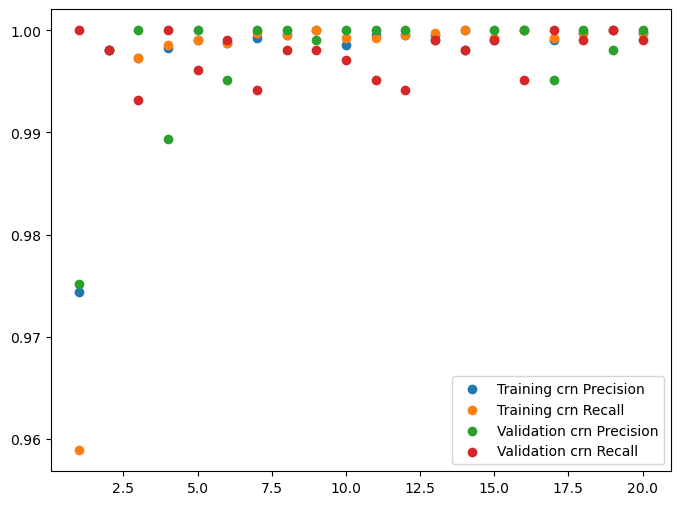

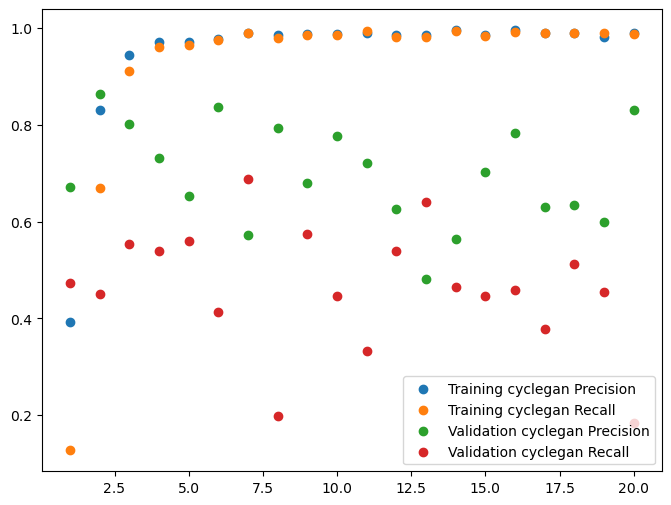

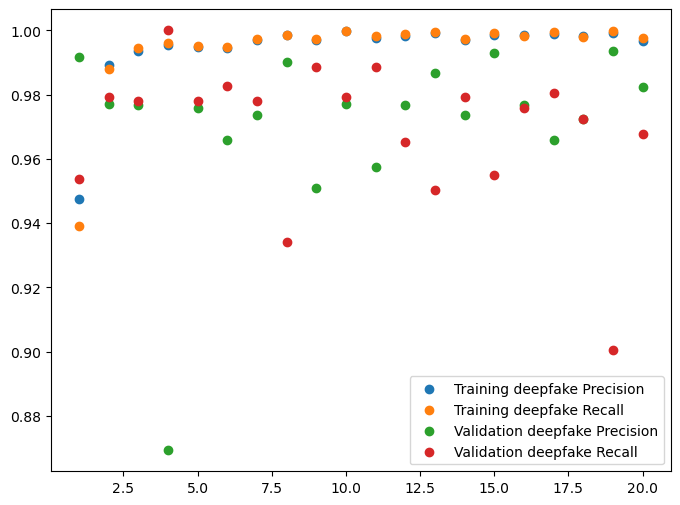

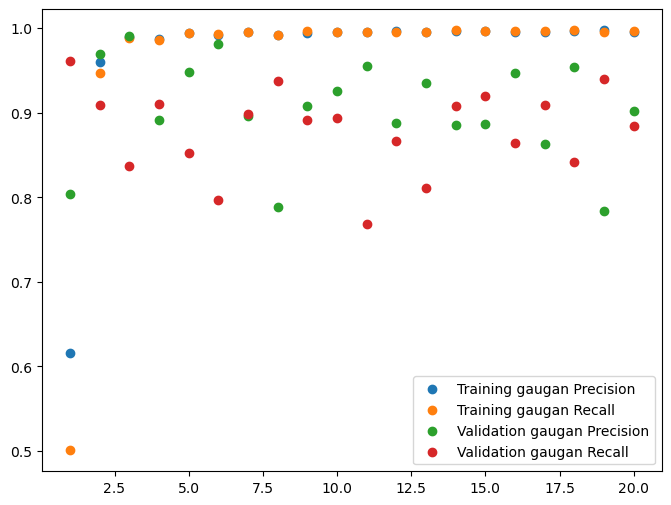

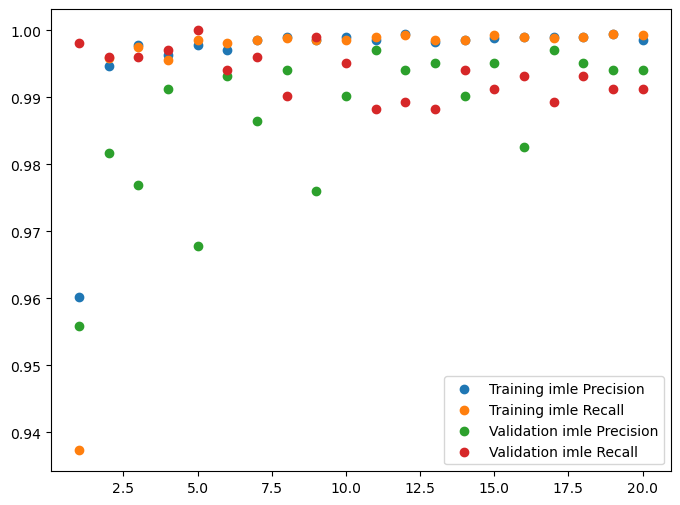

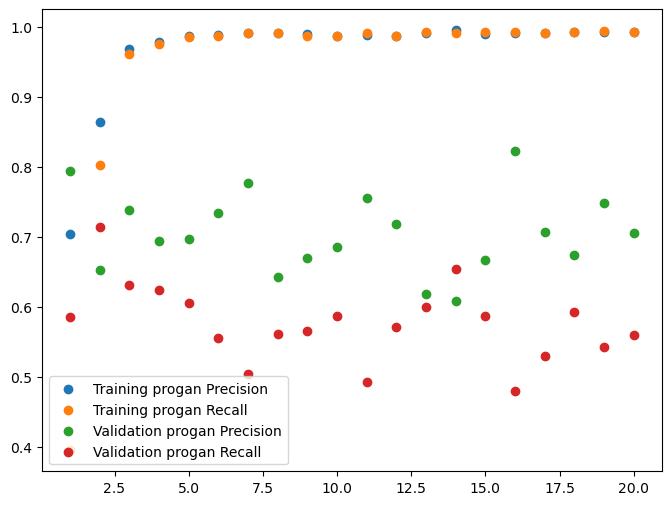

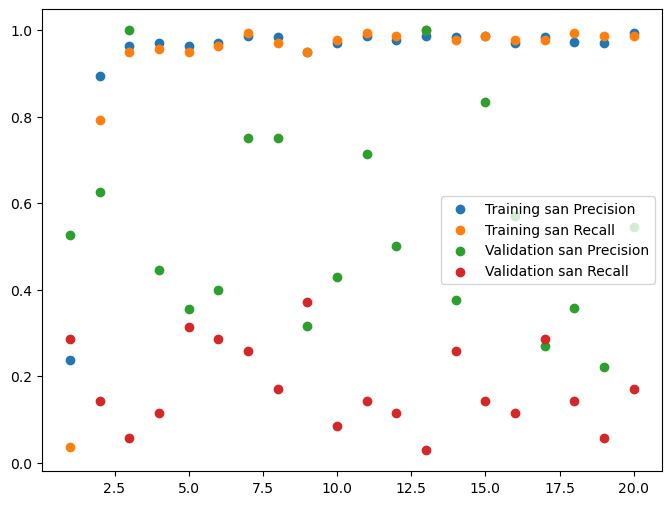

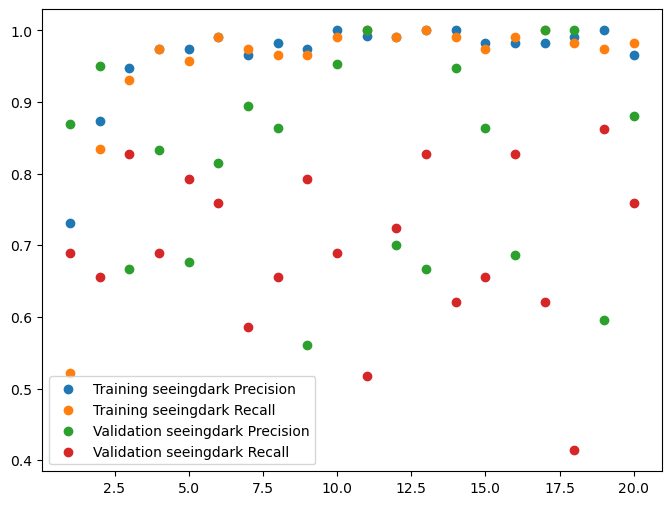

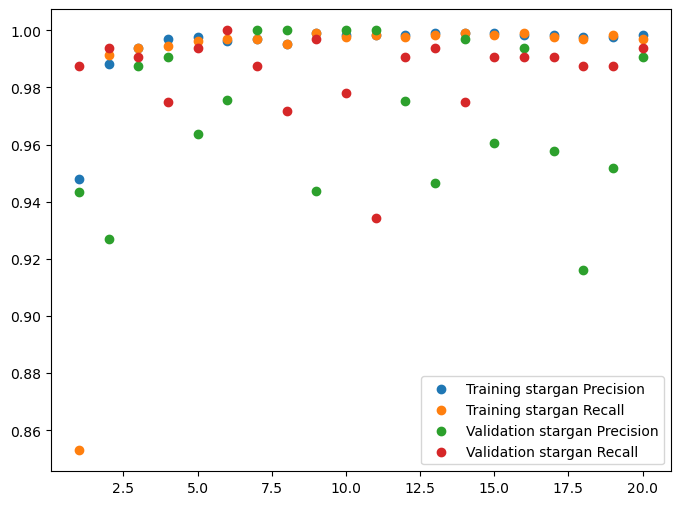

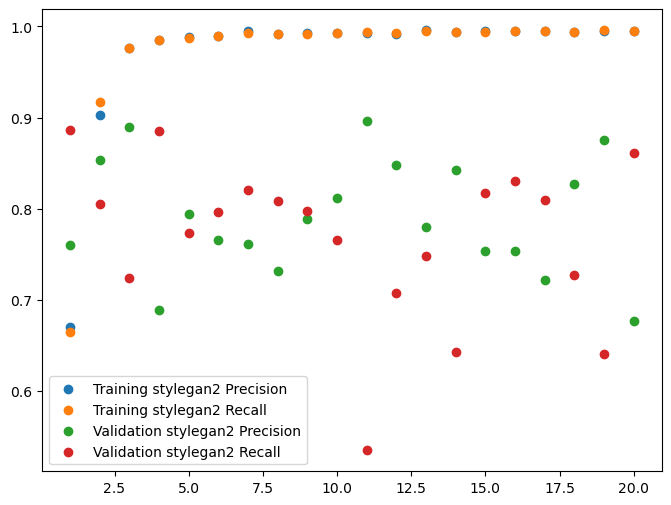

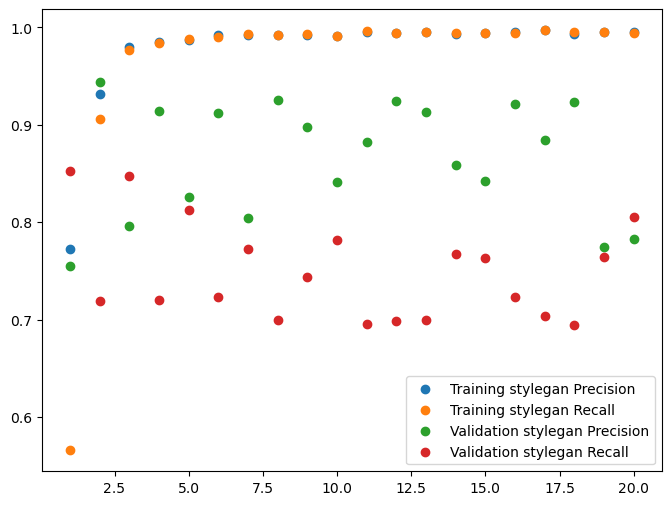

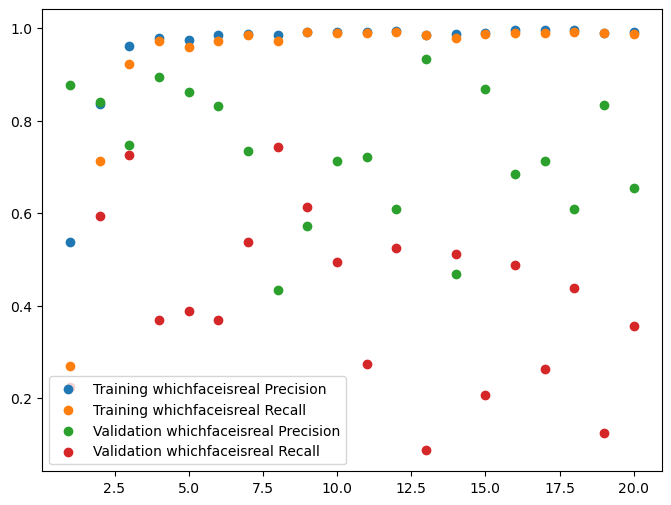

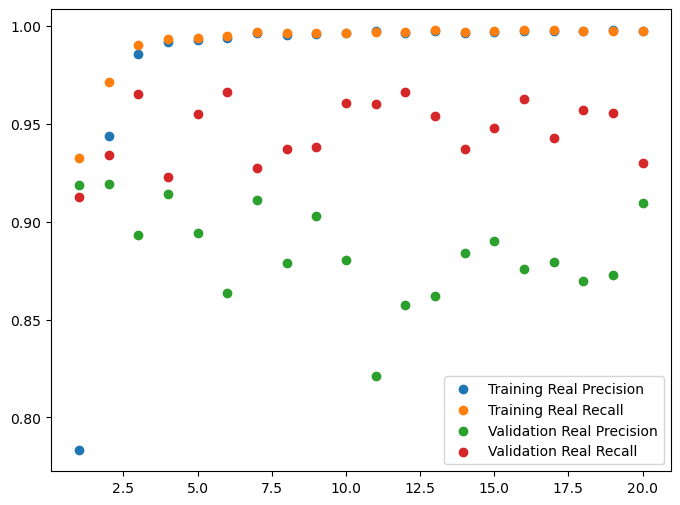

In [28]:
import matplotlib.pyplot as plt
for kwd in keywords:
    training_kwd_precision = "precision_" + kwd
    training_kwd_recall = "recall_" + kwd
    validation_kwd_precision = "val_precision_" + kwd
    validation_kwd_recall = "val_recall_" + kwd
    plt.figure(figsize = (8,6))
    plt.scatter(range(1,20 + 1), history_dict[training_kwd_precision], label = "Training " +kwd+ " Precision")
    plt.scatter(range(1,20 + 1), history_dict[training_kwd_recall], label = "Training " +kwd+ " Recall")
    plt.scatter(range(1,20 + 1), history_dict[validation_kwd_precision], label = "Validation " +kwd+ " Precision")
    plt.scatter(range(1,20 + 1), history_dict[validation_kwd_recall], label = "Validation " +kwd+ " Recall")
    plt.legend(fontsize = 10)
    plt.show()

plt.figure(figsize = (8,6))
plt.scatter(range(1,20 + 1), history_dict["precision_real"], label = "Training Real Precision")
plt.scatter(range(1,20 + 1), history_dict["recall_real"], label = "Training Real Recall")
plt.scatter(range(1,20 + 1), history_dict["val_precision_real"], label = "Validation Real Precision")
plt.scatter(range(1,20 + 1), history_dict["val_recall_real"], label = "Validation Real Recall")
plt.legend(fontsize = 10)
plt.show()


In [31]:
print("The epoch that had the highest validation real precision was",
     range(1,20+1)[np.argmax(history_dict['val_precision_real'])])

The epoch that had the highest validation real precision was 2


In [43]:
del model

In [44]:
model = models.Sequential()
model.add(layers.Conv2D( 32, (3,3), activation='relu', input_shape=(256,256,3,)))
model.add( layers.MaxPooling2D( (2,2), strides = 2 ) )
model.add( layers.Conv2D(64, (3,3), activation='relu'))
model.add( layers.MaxPooling2D( (2,2), strides=2) )
model.add( layers.Flatten() )
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(14, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 246016)            0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [46]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = [METRICS])
history = model.fit(train_sequence, epochs = 2, validation_data = validation_sequence)

Epoch 1/2
3613/3613 [==============================] - 428s 118ms/step - loss: 0.6778 - precision_biggan: 0.4876 - recall_biggan: 0.1356 - precision_crn: 0.9747 - recall_crn: 0.9444 - precision_cyclegan: 0.5420 - recall_cyclegan: 0.1220 - precision_deepfake: 0.9447 - recall_deepfake: 0.9433 - precision_gaugan: 0.7555 - recall_gaugan: 0.5230 - precision_imle: 0.9639 - recall_imle: 0.9218 - precision_progan: 0.6840 - recall_progan: 0.4275 - precision_san: 0.4000 - recall_san: 0.0805 - precision_seeingdark: 0.7027 - recall_seeingdark: 0.5417 - precision_stargan: 0.9462 - recall_stargan: 0.9024 - precision_stylegan2: 0.7009 - recall_stylegan2: 0.6958 - precision_stylegan: 0.7506 - recall_stylegan: 0.6537 - precision_whichfaceisreal: 0.5465 - recall_whichfaceisreal: 0.1175 - precision_real: 0.7898 - recall_real: 0.9371 - val_loss: 0.3848 - val_precision_biggan: 0.6047 - val_recall_biggan: 0.2438 - val_precision_crn: 0.9971 - val_recall_crn: 0.9990 - val_precision_cyclegan: 0.7321 - val_reca

In [96]:
model.save_weights("single_channel_model_best_val_real_precision_weights")
try:
    recalled_model
except NameError:
    pass
else:
    del recalled_model
#Unfortunately, because I am using an older version of keras, it appears I cannot save the model when I have custom metrics.
#Therefore, it seems that I need to save the weights.
#However, I have adjusted the metrics so they can be saved in newer keras versions by adding the get_config().

In [97]:
#Reconstruct model
#Do NOT run this more than once
recalled_model = models.Sequential()
recalled_model.add(layers.Conv2D( 32, (3,3), activation='relu', input_shape=(256,256,3,)))
recalled_model.add( layers.MaxPooling2D( (2,2), strides = 2 ) )
recalled_model.add( layers.Conv2D(64, (3,3), activation='relu'))
recalled_model.add( layers.MaxPooling2D( (2,2), strides=2) )
recalled_model.add( layers.Flatten() )
recalled_model.add(layers.Dense(64, activation='relu'))
recalled_model.add(layers.Dense(14, activation='softmax'))
recalled_model.load_weights("single_channel_model_best_val_real_precision_weights")
recalled_model.compile(optimizer='adam',
              loss='categorical_crossentropy')

In [98]:
#Check that the loaded model matches the original.
test_sequence = ImageBatchSequence(X_test, batch_size = 1, filter_function = HPF_filter, 
                                    output_function = categorical_output)
np.testing.assert_allclose(model.predict(test_sequence), recalled_model.predict(test_sequence))
#No error was thrown, so the two models are the same...

18063/18063 [==============================] - 102s 6ms/step
